Import essential libraries

In [7]:
import re
import copy
import torch
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn as nn
from tqdm import trange
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sentence_transformers import SentenceTransformer
from torch.optim.lr_scheduler import ReduceLROnPlateau

Helper functions

In [8]:
def plot_confusion_matrix(model, loader, classes):
    model.eval()
    y_pred = []
    y_test = []

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = outputs.argmax(dim=1)

            y_pred.extend(preds.cpu().numpy())
            y_test.extend(labels.cpu().numpy())

    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

Import datasets
<br>
ml-spring-nlp-dataset: https://www.kaggle.com/datasets/amirhosseinkanani/ml-spring-nlp-dataset
<br>
persian stop words: https://www.kaggle.com/datasets/alikhademi9876/stopwords

In [9]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
train_file_path = './NLP_Dataset/train.csv'

df = pd.read_csv(train_file_path, index_col=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6125 entries, 0 to 6124
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   text     6125 non-null   object
 1   emotion  6125 non-null   object
dtypes: object(2)
memory usage: 143.6+ KB


Preprocess dataset (Remove emojis, stopwords, and punctuations)

In [10]:
def remove_digits(text):
    return re.sub(r'[0-9]', '', text)

def preprocess_text(df):
    df['text'] = df['text'].apply(remove_digits)
    return df

df = preprocess_text(df)
df.info()
df

<class 'pandas.core.frame.DataFrame'>
Index: 6125 entries, 0 to 6124
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   text     6125 non-null   object
 1   emotion  6125 non-null   object
dtypes: object(2)
memory usage: 143.6+ KB


,text,emotion
0,خیلی کوچیک هستن و سایزشون بدرد نمیخوره میخوام ...,SAD
1,از صدای پرنده دم دمای صبح متنفرم متنفرم متنفرم,HATE
2,"""کیفیتش خیلی خوبه با شک خریدم ولی واقعا راضیم...",SAD
3,چون همش با دوربین ثبت شده ، ایا میشه اعتراض زد...,OTHER
4,اين وضع ب طرز خنده داري گريه داره ...,SAD
...,...,...
6120,مرحوم پیش بینی آبکی زیاد میکرد مرحوم عجب آ...,SURPRISE
6121,کلا عین اعتقادات و توئیت زدناتون ... !! در ق...,ANGRY
6122,خب وقتی میگی کسی بیاد مارو بگیره یارو ترس میکن...,FEAR
6123,همون هارو مگه آهنگ جدیدای خواننده‌های دهه ...,SURPRISE


Label encode the data (also save the encoder for future use)

In [11]:
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['emotion'])
joblib.dump(label_encoder, 'Model_Files/label_encoder.pkl')

df.drop(columns=['emotion'], inplace=True)
df

,text,label
0,خیلی کوچیک هستن و سایزشون بدرد نمیخوره میخوام ...,5
1,از صدای پرنده دم دمای صبح متنفرم متنفرم متنفرم,3
2,"""کیفیتش خیلی خوبه با شک خریدم ولی واقعا راضیم...",5
3,چون همش با دوربین ثبت شده ، ایا میشه اعتراض زد...,4
4,اين وضع ب طرز خنده داري گريه داره ...,5
...,...,...
6120,مرحوم پیش بینی آبکی زیاد میکرد مرحوم عجب آ...,6
6121,کلا عین اعتقادات و توئیت زدناتون ... !! در ق...,0
6122,خب وقتی میگی کسی بیاد مارو بگیره یارو ترس میکن...,1
6123,همون هارو مگه آهنگ جدیدای خواننده‌های دهه ...,6


Load ParsBERT model and embed sentences

In [12]:
model_name = "HooshvareLab/bert-fa-base-uncased"
sbert_model = SentenceTransformer(model_name)
sbert_model.to(device)

# Function to get sentence embeddings using SBERT
def get_sentence_embeddings(sentences, model, batch_size=256):
    all_embeddings = [] 

    for i in range(0, len(sentences), batch_size):
        batch = sentences[i:i+batch_size]
        embeddings = model.encode(batch, show_progress_bar=True, device=device)
        all_embeddings.append(embeddings)
    
    return np.vstack(all_embeddings)

embeddings = get_sentence_embeddings(df['text'].tolist(), sbert_model)
embeddings = np.array(embeddings)
print(embeddings.shape)

No sentence-transformers model found with name HooshvareLab/bert-fa-base-uncased. Creating a new one with mean pooling.


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

(6125, 768)


Define NLP class extending pytorch class

In [13]:
class NLPDataset(Dataset):
    def __init__(self, embeddings, labels):
        self.embeddings = embeddings
        self.labels = labels
    
    def __len__(self):
        return len(self.embeddings)
    
    def __getitem__(self, idx):
        idx = int(idx)
        return torch.tensor(self.embeddings[idx], dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.long)

Split train portion into train and validation

In [14]:
X_train, X_val, y_train, y_val = train_test_split(embeddings, df['label'], test_size=0.05, random_state=42, stratify=df['label'])
X_train.shape, X_val.shape, y_train.shape, y_val.shape

y_train = y_train.reset_index(drop=True).values
y_val = y_val.reset_index(drop=True).values

train_dataset = NLPDataset(X_train, y_train)
val_dataset = NLPDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False)

Model training functions

In [15]:
def train_epoch(model, dataloader, loss_fn, optimizer):
    model.train()
    train_loss = 0.0
    all_preds = []
    all_labels = []

    for texts, labels in dataloader:
        texts, labels = texts.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(texts)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    avg_loss = train_loss / len(dataloader)
    f1_macro = f1_score(all_labels, all_preds, average='macro') * 100
    return avg_loss, f1_macro

def evaluate_model(model, dataloader, loss_fn):
    model.eval()
    total_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for texts, labels in dataloader:
            texts, labels = texts.to(device), labels.to(device)

            outputs = model(texts)
            loss = loss_fn(outputs, labels)
            total_loss += loss.item()

            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(dataloader)
    f1_macro = f1_score(all_labels, all_preds, average='macro') * 100
    return avg_loss, f1_macro

def train_model(model, train_loader, val_loader, optimizer, n_epochs, loss_fn, weight=False, patience=5):
    model.to(device)

    if weight:
        class_counts = pd.Series(y_train).value_counts()
        class_weights = 1.0 / torch.tensor(class_counts.values, dtype=torch.float32)
        class_weights = class_weights / class_weights.sum()
        class_weights = class_weights.to(device)

        loss_fn.weight = class_weights

    train_losses, val_losses = np.empty(n_epochs), np.empty(n_epochs)
    train_f1 = np.empty(n_epochs)
    val_f1 = np.empty(n_epochs)
    best_val_loss = float('inf')

    best_state = model.state_dict()
    patience_counter = 0

    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=int(patience / 2))

    current_lr = scheduler.get_last_lr()

    for epoch in (pbar := trange(n_epochs)):
        running_loss, running_train_f1 = train_epoch(model, train_loader, loss_fn, optimizer)
        train_losses[epoch] = running_loss

        val_loss, running_val_f1 = evaluate_model(model, val_loader, loss_fn)
        val_losses[epoch] = val_loss

        train_f1[epoch] = running_train_f1
        val_f1[epoch] = running_val_f1

        if patience:
            if epoch == 0 or val_losses[epoch] < best_val_loss - 1e-5:
                patience_counter = 0
                best_val_loss = val_losses[epoch]
                best_state = copy.deepcopy(model.state_dict())
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"\nEarly stopping at epoch {epoch+1}")
                    model.load_state_dict(best_state)
                    return train_losses[:epoch], val_losses[:epoch], train_f1[:epoch], val_f1[:epoch]

        pbar.set_description(f"Epoch {epoch+1} | Train Loss: {running_loss:.3f} | Validation Loss: {val_loss:.3f} % | Train F1-Score Macro: {running_train_f1:.3f} % | Validation F1-Score Macro: {running_val_f1:.3f} | Learning Rate: {scheduler.get_last_lr()} | Patience: {patience - patience_counter}")

        scheduler.step(val_loss)
        if scheduler.get_last_lr() != current_lr:
            print(f'Reducing learning rate to {scheduler.get_last_lr()}')
        current_lr = scheduler.get_last_lr()

    if patience:
        model.load_state_dict(best_state)

    return train_losses, val_losses, train_f1, val_f1

def plot_training_curves(train_losses, val_losses, train_acc, val_acc):
    epochs = np.arange(1, len(train_losses) + 1)

    plt.figure(figsize=(14, 5))

    # Plot Losses
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss', marker='o')
    plt.plot(epochs, val_losses, label='Validation Loss', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss over Epochs')
    plt.legend()
    plt.grid(True)

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, label='Train F1', marker='o', color='green')
    plt.plot(epochs, val_acc, label='Validation F1', marker='o', color='orange')
    plt.xlabel('Epoch')
    plt.ylabel('F1 (%)')
    plt.title('F1 over Epochs')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

NN model structure

In [16]:
class SentimentNN(nn.Module):
    def __init__(self, input_dim=768, output_dim=7, dropout_rate=0.5):
        super(SentimentNN, self).__init__()
        
        self.fc1 = nn.Linear(input_dim, 512)
        self.relu = nn.ReLU()
        
        self.fc2 = nn.Linear(512, 512)
        self.relu = nn.ReLU()
        
        self.fc3 = nn.Linear(512, 256)
        self.relu = nn.ReLU()
        
        self.fc4 = nn.Linear(256, output_dim)
        
        self.dropout = nn.Dropout(dropout_rate)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.fc3(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.fc4(x)
        return x

model = SentimentNN(input_dim=768, output_dim=7, dropout_rate=0.5).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)
train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model,
    train_loader,
    val_loader,
    optimizer,
    n_epochs=100,
    loss_fn=nn.CrossEntropyLoss(),
    weight=False,
    patience=10
)

Epoch 20 | Train Loss: 0.756 | Validation Loss: 1.197 % | Train F1-Score Macro: 72.468 % | Validation F1-Score Macro: 55.161 | Learning Rate: [0.001] | Patience: 4:  20%|██        | 20/100 [00:05<00:21,  3.79it/s] 

Reducing learning rate to [0.0001]


Epoch 23 | Train Loss: 0.615 | Validation Loss: 1.186 % | Train F1-Score Macro: 78.263 % | Validation F1-Score Macro: 58.766 | Learning Rate: [0.0001] | Patience: 1:  23%|██▎       | 23/100 [00:06<00:23,  3.30it/s]


Early stopping at epoch 24


Import test dataset and perform necessary data preperation

In [ ]:
test_file_path = './NLP_Dataset/test.csv'

test_df = pd.read_csv(test_file_path, index_col=0)

test_df = preprocess_text(test_df)

test_df['label'] = label_encoder.fit_transform(test_df['emotion'])
test_df.drop(columns=['emotion'], inplace=True)

embeddings = get_sentence_embeddings(test_df['text'].tolist(), sbert_model)
embeddings = np.array(embeddings)

y_test = test_df['label'].reset_index(drop=True).values

test_dataset = NLPDataset(embeddings, y_test)

test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Function to evaluate f1-macro

In [18]:
def evaluate_f1_macro(model, dataloader):
    model.eval()
    y_test, y_pred = [], []

    with torch.no_grad():
        for batch in dataloader:
            inputs, labels = batch  # assuming batch contains inputs and labels
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Get predictions
            outputs = model(inputs)
            preds = outputs.argmax(dim=1)

            # Collect all predictions and labels
            y_pred.extend(preds.cpu().numpy())
            y_test.extend(labels.cpu().numpy())

    f1 = f1_score(y_test, y_pred, average='macro')
    print(f'Test f1 on {len(dataloader.dataset)} samples: {f1:.2f}%')
    
    return y_test, y_pred

Test the model (f1-macro) using validation and test set and draw confusion matrix

Model f1 on train dataset:
Test f1 on 5818 samples: 0.73%
Model f1 on val dataset:
Test f1 on 307 samples: 0.58%
Model f1 on test dataset:
Test f1 on 1151 samples: 0.43%


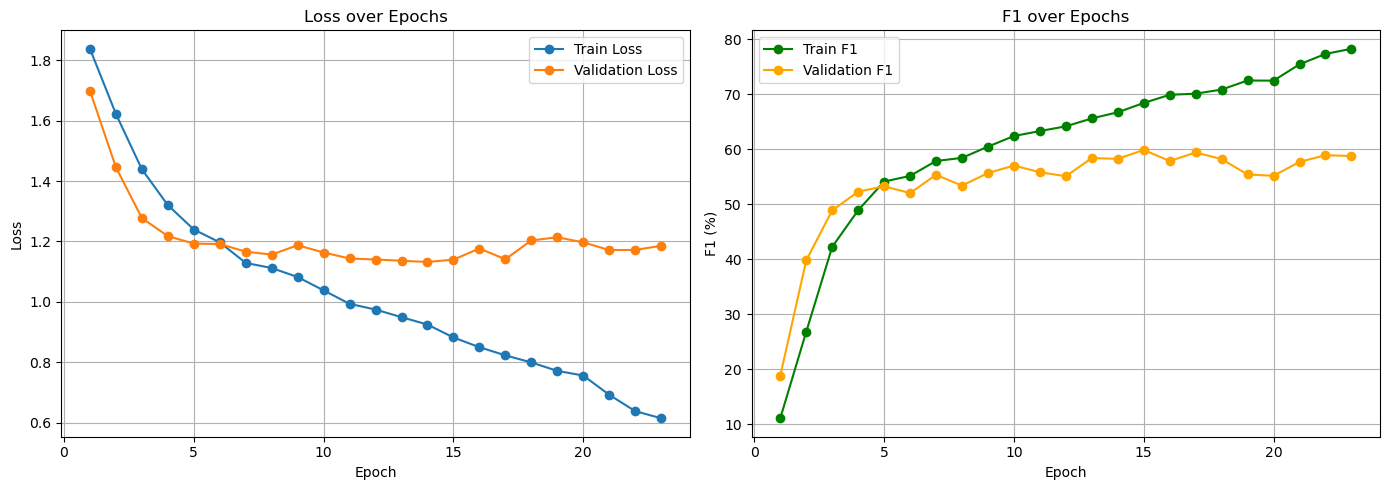

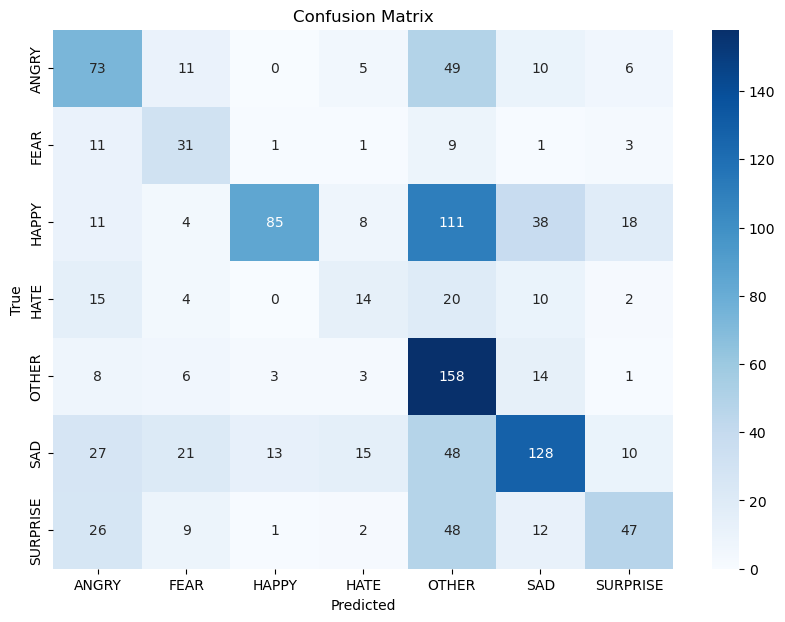

In [19]:
print('Model f1 on train dataset:')
evaluate_f1_macro(model, train_loader)

print('Model f1 on val dataset:')
evaluate_f1_macro(model, val_loader)

print('Model f1 on test dataset:')
y_test, y_pred = evaluate_f1_macro(model, test_loader)

plot_training_curves(train_losses, val_losses, train_accuracies, val_accuracies)

plot_confusion_matrix(model, test_loader, label_encoder.classes_)

compute f1 for each class in order to evaluate which classes are performing better

In [20]:
def compute_f1_per_class(model, test_loader, device, classes):
    model.eval()  # Set the model to evaluation mode
    y_test, y_pred = [], []

    with torch.no_grad():
        for batch in test_loader:
            inputs, labels = batch  # assuming batch contains inputs and labels
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Get predictions
            outputs = model(inputs)
            preds = outputs.argmax(dim=1)

            # Collect all predictions and labels
            y_pred.extend(preds.cpu().numpy())
            y_test.extend(labels.cpu().numpy())

    # Compute the F1-Score for each class (using average=None to get scores per class)
    f1_per_class = f1_score(y_test, y_pred, average=None)

    # Print F1-Score per class
    print("F1-Score per class:\n")
    for i, score in enumerate(f1_per_class):
        print(f"{classes[i]}: {score:.4f}")

    return f1_per_class

f1_scores = compute_f1_per_class(model, test_loader, device, label_encoder.classes_)

F1-Score per class:

ANGRY: 0.4492
FEAR: 0.4336
HAPPY: 0.4497
HATE: 0.2478
OTHER: 0.4969
SAD: 0.5389
SURPRISE: 0.4052


Compute data distribution between classes

In [21]:
y_train_series = pd.Series(y_train)
y_train_series = y_train_series.map(lambda x: label_encoder.classes_[x])
percentages = y_train_series.value_counts(normalize=True).sort_index() * 100
percentages = percentages.round(2)
print(percentages)

ANGRY       15.07
FEAR        12.36
HAPPY       10.09
HATE         8.34
OTHER       27.45
SAD         14.63
SURPRISE    12.07
Name: proportion, dtype: float64


Compute data distribution between classes (test dataset)

In [22]:
y_test_series = pd.Series(y_test)
y_test_series = y_test_series.map(lambda x: label_encoder.classes_[x])
percentages = y_test_series.value_counts(normalize=True).sort_index() * 100
percentages = percentages.round(2)
print(percentages)

ANGRY       13.38
FEAR         4.95
HAPPY       23.89
HATE         5.65
OTHER       16.77
SAD         22.76
SURPRISE    12.60
Name: proportion, dtype: float64


Save model as pkl file (for API creation)

In [24]:
example_input = torch.rand(1, 768).to(device)
scripted_model = torch.jit.trace(model, example_input)
scripted_model.save('Model_Files/sentiment_model.pt')

Revised model using class weights to train the model

In [25]:
model = SentimentNN(input_dim=768, output_dim=7, dropout_rate=0.5).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)
train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model,
    train_loader,
    val_loader,
    optimizer,
    n_epochs=100,
    loss_fn=nn.CrossEntropyLoss(),
    weight=True,
    patience=10
)

Epoch 15 | Train Loss: 0.881 | Validation Loss: 1.268 % | Train F1-Score Macro: 64.008 % | Validation F1-Score Macro: 53.992 | Learning Rate: [0.001] | Patience: 4:  15%|█▌        | 15/100 [00:03<00:20,  4.16it/s]

Reducing learning rate to [0.0001]


Epoch 18 | Train Loss: 0.737 | Validation Loss: 1.255 % | Train F1-Score Macro: 69.888 % | Validation F1-Score Macro: 54.256 | Learning Rate: [0.0001] | Patience: 1:  18%|█▊        | 18/100 [00:04<00:22,  3.70it/s]


Early stopping at epoch 19


Model accuracy on train dataset:
Test f1 on 5818 samples: 0.66%
Model accuracy on val dataset:
Test f1 on 307 samples: 0.56%
Model accuracy on test dataset:
Test f1 on 1151 samples: 0.45%


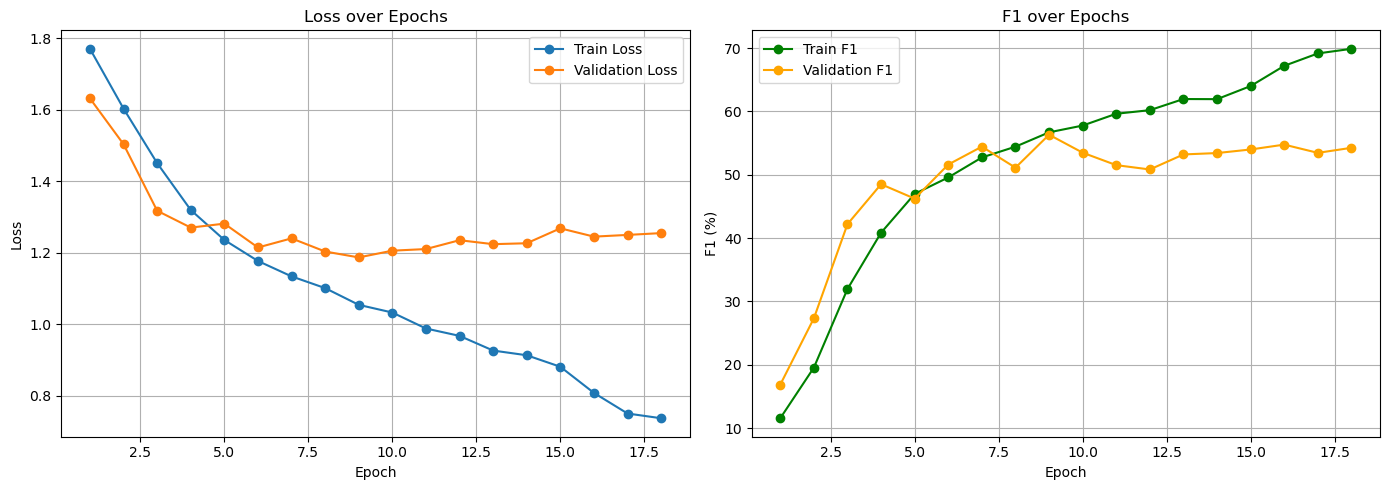

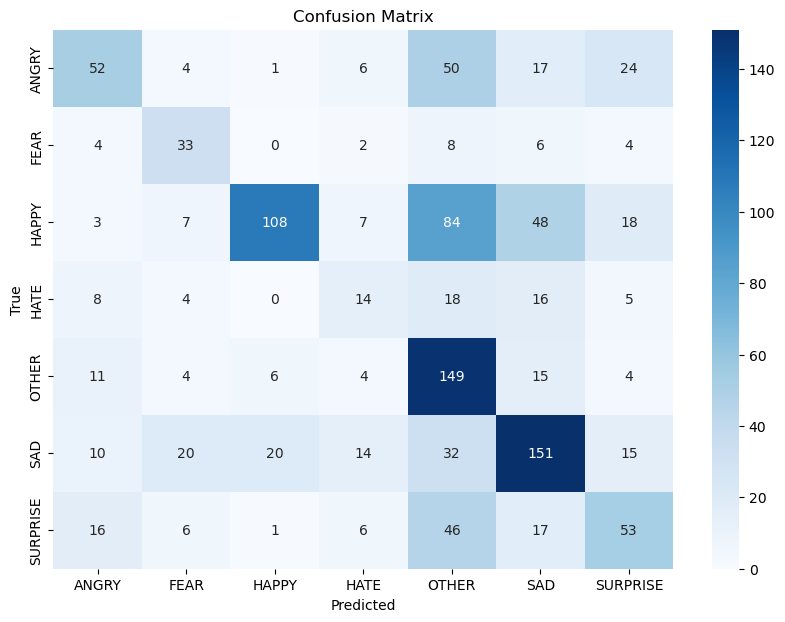

In [26]:
print('Model accuracy on train dataset:')
evaluate_f1_macro(model, train_loader)

print('Model accuracy on val dataset:')
evaluate_f1_macro(model, val_loader)

print('Model accuracy on test dataset:')
evaluate_f1_macro(model, test_loader)

plot_training_curves(train_losses, val_losses, train_accuracies, val_accuracies)

plot_confusion_matrix(model, test_loader, label_encoder.classes_)

Revised pretraining method using resampling to normalize class distributions

In [27]:
from collections import Counter

# Check the class distribution
class_distribution = Counter(y_train)

# Define the desired class size (e.g., the maximum class size)
max_class_size = max(class_distribution.values())

# Create a new training dataset with oversampling
X_resampled, y_resampled = [], []

for i in range(len(X_train)):
    X_resampled.append(X_train[i])
    y_resampled.append(y_train[i])

    # Oversample minority classes by duplicating them
    while len(y_resampled) < max_class_size:
        X_resampled.append(X_train[i])
        y_resampled.append(y_train[i])

# Now use the resampled dataset
y_train_resampled = np.array(y_resampled)
train_dataset_resampled = NLPDataset(X_resampled, y_train_resampled)
train_loader_resampled = DataLoader(train_dataset_resampled, batch_size=256, shuffle=True)

# Train the model on the resampled dataset
model = SentimentNN(input_dim=768, output_dim=7, dropout_rate=0.5).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)
train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model,
    train_loader_resampled,
    val_loader,
    optimizer,
    n_epochs=100,
    loss_fn=nn.CrossEntropyLoss(),
    weight=True,
    patience=10
)

Epoch 18 | Train Loss: 0.597 | Validation Loss: 1.255 % | Train F1-Score Macro: 67.714 % | Validation F1-Score Macro: 52.735 | Learning Rate: [0.001] | Patience: 4:  18%|█▊        | 18/100 [00:05<00:26,  3.07it/s] 

Reducing learning rate to [0.0001]


Epoch 21 | Train Loss: 0.487 | Validation Loss: 1.269 % | Train F1-Score Macro: 73.353 % | Validation F1-Score Macro: 54.481 | Learning Rate: [0.0001] | Patience: 1:  21%|██        | 21/100 [00:07<00:27,  2.92it/s]


Early stopping at epoch 22


Model accuracy on train dataset:
Test f1 on 5818 samples: 0.69%
Model accuracy on val dataset:
Test f1 on 307 samples: 0.56%
Model accuracy on test dataset:
Test f1 on 1151 samples: 0.43%


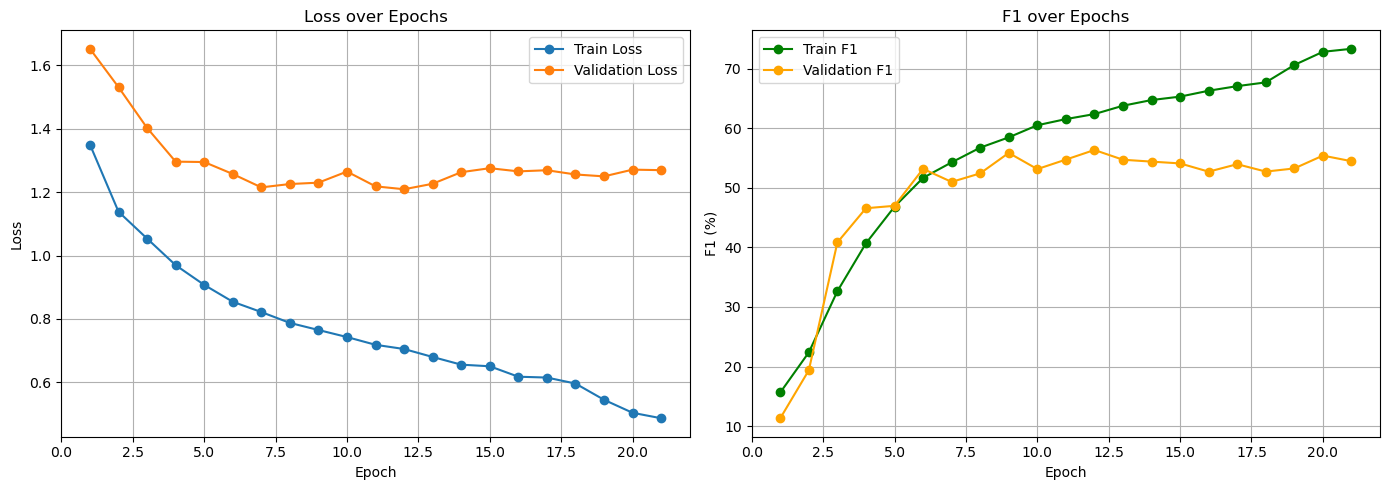

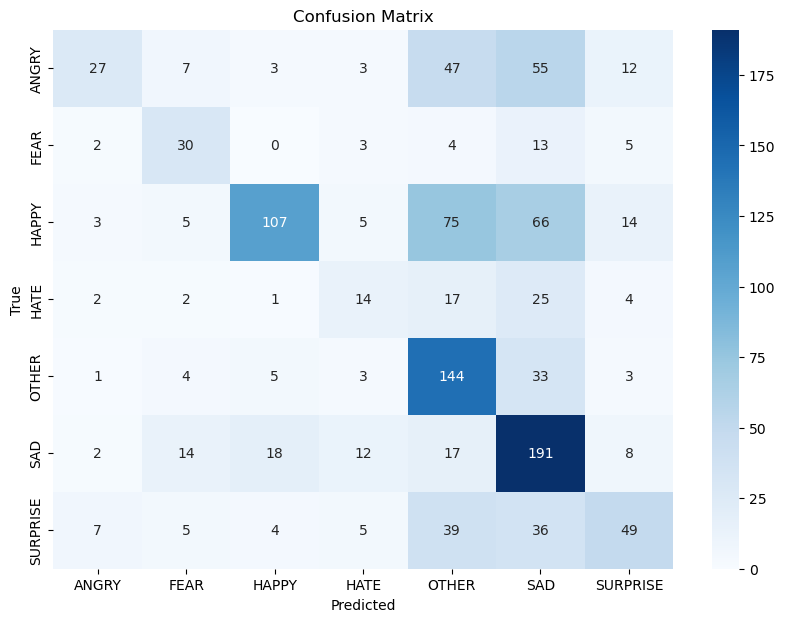

In [28]:
print('Model accuracy on train dataset:')
evaluate_f1_macro(model, train_loader)

print('Model accuracy on val dataset:')
evaluate_f1_macro(model, val_loader)

print('Model accuracy on test dataset:')
evaluate_f1_macro(model, test_loader)
plot_training_curves(train_losses, val_losses, train_accuracies, val_accuracies)

plot_confusion_matrix(model, test_loader, label_encoder.classes_)